In [322]:
## Main
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Torch
import torch
from torch import nn
from torch.optim import Adam, RMSprop
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal

## OT
import ot
from ot import wasserstein_1d

In [332]:
class Sinkhorn():
    
    def __init__(self, eps, device=torch.device("cpu")):
        self.eps = eps
        self.device = device
        
    def forward(self, a, b, C, n_iter=100):
        K = torch.exp(-C/self.eps)
        v = torch.ones(b.shape[0], device=self.device)
        for _ in range(n_iter):
            u = a / (K@v)
            v = b / (K.T@u)
            
        return ((torch.diag(u)@K)@torch.diag(v))
        
    def __call__(self, a, b, C, n_iter=100):
        return self.forward(a, b, C, n_iter)
    
class WeightClipper(object):

    def __init__(self, c=0.01):
        self.c = c

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-self.c,self.c)
            module.weight.data = w

In [333]:
cfg = {
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "batch_size":torch.Size([64]),
    "batch_size_1D":torch.Size([64, 1]),
    "val_batch_size":torch.Size([100]),
    "num_epochs":500,
    "w_gp":10,
}

### $x_1 \sim \mathcal{N}(0,1), x_2 \sim \mathcal{N}(1,1),$ Dataset

In [381]:
size = 1

mean1 = 0
cov1 = 1

mean2 = 1
cov2 = 1

dist1 = Normal(mean1, cov1)
dist2 = Normal(mean2, cov2)

train_epoches = 500
val_epoches = 100

### Models

#### WGAN Clip

In [382]:
netD_Clip = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

clipper = WeightClipper(0.01)
optimD_Clip = RMSprop(netD_Clip.parameters(), lr=5e-4)

#### WGAN Gradient Penalty

In [383]:
netD_GP = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

optimD_GP = Adam(netD_GP.parameters(), lr=1e-3, betas=(0, 0.9))

#### $(c)$-GAN

In [384]:
netD_C = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

optimD_C = RMSprop(netD_C.parameters(), lr=1e-4)

#### $(C, \epsilon)$-GAN

In [385]:
netD_C_eps = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

eps = 1
optimD_C_eps = RMSprop(netD_C_eps.parameters(), lr=1e-4)

#### Sinkhorn

In [386]:
sinkhorn = Sinkhorn(eps=0.01)

#### Experiments

In [387]:
losses = {
    "WGANGP": [],
    "WGANClip": [],
    "WGANc": [],
    "WGANc_eps": [],
    "Sinkhorn": [],
    "Wasserstain 1": [],
}

for epoch in (pbar := tqdm(range(train_epoches))):
    X_1_batch = dist1.rsample(cfg["batch_size_1D"]).to(cfg['device'])
    X_2_batch = dist2.rsample(cfg["batch_size_1D"]).to(cfg['device'])

    
    ### WGANClip
    optimD_Clip.zero_grad()
    e_X_1 = netD_Clip(X_1_batch).mean()
    e_X_2 = netD_Clip(X_2_batch).mean()
    netD_loss = e_X_1 - e_X_2 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()
    
    optimD_Clip.step()
    
    netD_Clip.apply(clipper)
    
    losses["WGANClip"].append(netD_loss.item())
    
    
    ### WGANGP
    optimD_GP.zero_grad()
    e_X_1 = netD_GP(X_1_batch).mean()
    e_X_2 = netD_GP(X_2_batch).mean()

    netD_loss = e_X_2 - e_X_1 

    mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
    mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
    mixed.requires_grad_(True)
    mixed_preds = netD_GP(mixed).sum()
    grads = torch.autograd.grad(
        outputs=mixed_preds,
        inputs=mixed,
        create_graph=True,
        retain_graph=True,
    )[0]
    grads = grads.view(len(X_1_batch), -1)
    grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

    netD_total_loss = -(netD_loss - cfg['w_gp'] * grad_loss)
    netD_total_loss.backward()
    optimD_GP.step()

    losses["WGANGP"].append(netD_loss.item())

    
    ### WGAN (c)
    optimD_C.zero_grad()
    phi_X_1 = netD_C(X_1_batch)
    phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C.step()
    losses["WGANc"].append(netD_loss.item())
    
    
    ### WGAN (c, eps)
    optimD_C_eps.zero_grad()
    phi_X_1 = netD_C_eps(X_1_batch)
    phi_X_2 = -eps*torch.log(
                            torch.mean(
                                torch.exp(
                                    -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                ), 
                            1, keepdims=True)
                        )

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C_eps.step()
    losses["WGANc_eps"].append(netD_loss.item())
    
    
    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=1)
        a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
    ### Wasserstain Distance OT
    losses["Wasserstain 1"].append(
            wasserstein_1d(
                X_1_batch.flatten().numpy(),
                X_2_batch.flatten().numpy(),
                p=1
            )
        )
    
    
for epoch in (pbar := tqdm(range(val_epoches))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(cfg["batch_size_1D"]).to(cfg['device'])
        X_2_batch = dist2.rsample(cfg["batch_size_1D"]).to(cfg['device'])

        ### WGAN Clip
        e_X_1 = netD_Clip(X_1_batch).mean()
        e_X_2 = netD_Clip(X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        losses["WGANClip"].append(netD_loss.item())

        ### WGANGP
        e_X_1 = netD_GP(X_1_batch).mean()
        e_X_2 = netD_GP(X_2_batch).mean()

        netD_loss = e_X_2 - e_X_1 
        losses["WGANGP"].append(netD_loss.item())


        ### WGAN (c)
        phi_X_1 = netD_C(X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 
        losses["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        phi_X_1 = netD_C_eps(X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                         -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        losses["WGANc_eps"].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=1)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())
            
        ### Wasserstain Distance OT
            losses["Wasserstain 1"].append(
                    wasserstein_1d(
                        X_1_batch.flatten().numpy(),
                        X_2_batch.flatten().numpy(),
                        p=1
                    )
                )

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

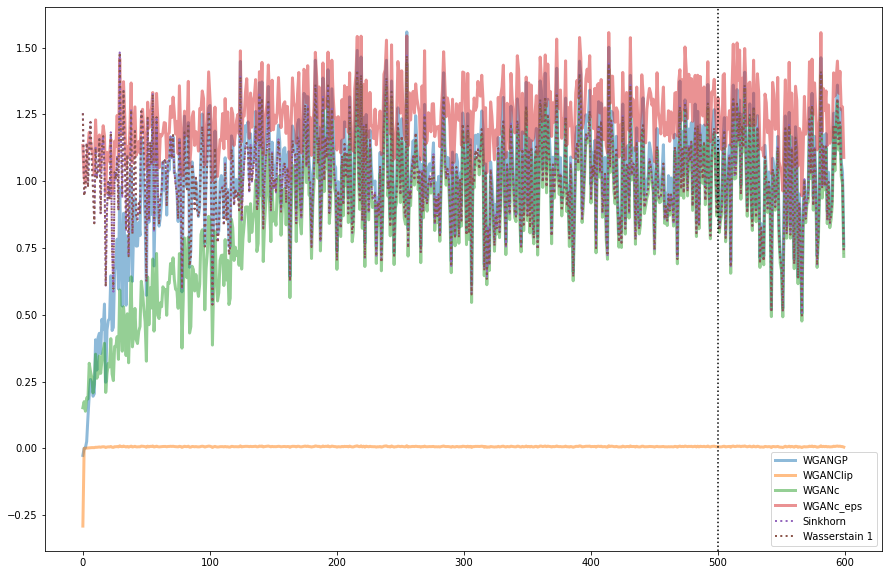

In [405]:
plt.figure(figsize=(15, 10))
for key, loss in losses.items():
    linestyle = ":" if key in ["Sinkhorn", "Wasserstain 1"] else None
    linewidth = 2 if key in ["Sinkhorn", "Wasserstain 1"] else 3
    alpha = 1 if key in ["Sinkhorn", "Wasserstain 1"] else 0.5
    plt.plot(loss, 
             label=key, 
             linestyle=linestyle,
             linewidth=linewidth,
             alpha=alpha
            )
    
plt.axvline(train_epoches, c="black", linestyle=linestyle)
plt.legend()
plt.show()

### Multinomial Dataset

In [406]:
size = 3
mean1 = torch.arange(size, dtype=torch.float32)
cov1_tril = torch.tril(torch.rand((size, size)))
cov1 = cov1_tril@cov1_tril.T

mean2 = torch.arange(size, size*2, dtype=torch.float32)
cov2_tril = torch.tril(torch.rand((size, size)))
cov2 = cov2_tril@cov2_tril.T

dist1 = MultivariateNormal(mean1, cov1)
dist2 = MultivariateNormal(mean2, cov2)

train_epoches = 1000
val_epoches = 100

### Models

#### WGAN Clip

In [407]:
netD_Clip = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

clipper = WeightClipper(0.01)
optimD_Clip = RMSprop(netD_Clip.parameters(), lr=5e-4)

#### WGAN Gradient Penalty

In [408]:
netD_GP = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

optimD_GP = Adam(netD_GP.parameters(), lr=1e-3, betas=(0, 0.9))

#### $(c)$-GAN

In [409]:
netD_C = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

optimD_C = RMSprop(netD_C.parameters(), lr=1e-4)

#### $(C, \epsilon)$-GAN

In [410]:
netD_C_eps = nn.Sequential(
    nn.Linear(size, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
).to(cfg["device"])

eps = 1
optimD_C_eps = RMSprop(netD_C_eps.parameters(), lr=1e-4)

#### Sinkhorn

In [411]:
sinkhorn = Sinkhorn(eps=0.01)

#### Experiments

In [412]:
losses = {
    "WGANGP": [],
    "WGANClip": [],
    "WGANc": [],
    "WGANc_eps": [],
    "Sinkhorn": [],
}

for epoch in (pbar := tqdm(range(train_epoches))):
    X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
    X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

    ### WGANClip
    optimD_Clip.zero_grad()
    e_X_1 = netD_Clip(X_1_batch).mean()
    e_X_2 = netD_Clip(X_2_batch).mean()
    netD_loss = e_X_1 - e_X_2 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()
    
    optimD_Clip.step()
    
    netD_Clip.apply(clipper)
    losses["WGANClip"].append(netD_loss.item())
    
    ### WGANGP
    optimD_GP.zero_grad()
    e_X_1 = netD_GP(X_1_batch).mean()
    e_X_2 = netD_GP(X_2_batch).mean()

    netD_loss = e_X_1 - e_X_2 

    mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
    mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
    mixed.requires_grad_(True)
    mixed_preds = netD_GP(mixed).sum()
    grads = torch.autograd.grad(
        outputs=mixed_preds,
        inputs=mixed,
        create_graph=True,
        retain_graph=True,
    )[0]
    grads = grads.view(len(X_1_batch), -1)
    grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

    netD_total_loss = -(netD_loss - cfg['w_gp'] * grad_loss)
    netD_total_loss.backward()
    optimD_GP.step()

    losses["WGANGP"].append(netD_loss.item())

    ### WGAN (c)
    optimD_C.zero_grad()
    phi_X_1 = netD_C(X_1_batch)
    phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C.step()
    losses["WGANc"].append(netD_loss.item())
    
    ### WGAN (c, eps)
    optimD_C_eps.zero_grad()
    phi_X_1 = netD_C_eps(X_1_batch)
    phi_X_2 = -eps*torch.log(
                            torch.mean(
                                torch.exp(
                                    -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                ), 
                            1, keepdims=True)
                        )

    netD_loss = phi_X_1.mean() + phi_X_2.mean() 

    netD_total_loss = -(netD_loss)
    netD_total_loss.backward()

    optimD_C_eps.step()
    losses["WGANc_eps"].append(netD_loss.item())
    
    
    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=1)
        a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
for epoch in (pbar := tqdm(range(val_epoches))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
        X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

        ### WGAN Clip
        e_X_1 = netD_Clip(X_1_batch).mean()
        e_X_2 = netD_Clip(X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 
        losses["WGANClip"].append(netD_loss.item())

        ### WGANGP
        e_X_1 = netD_GP(X_1_batch).mean()
        e_X_2 = netD_GP(X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 
        losses["WGANGP"].append(netD_loss.item())


        ### WGAN (c)
        phi_X_1 = netD_C(X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 
        losses["WGANc"].append(netD_loss.item())

        ### WGAN (c, eps)
        phi_X_1 = netD_C_eps(X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                         -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        losses["WGANc_eps"].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=1)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

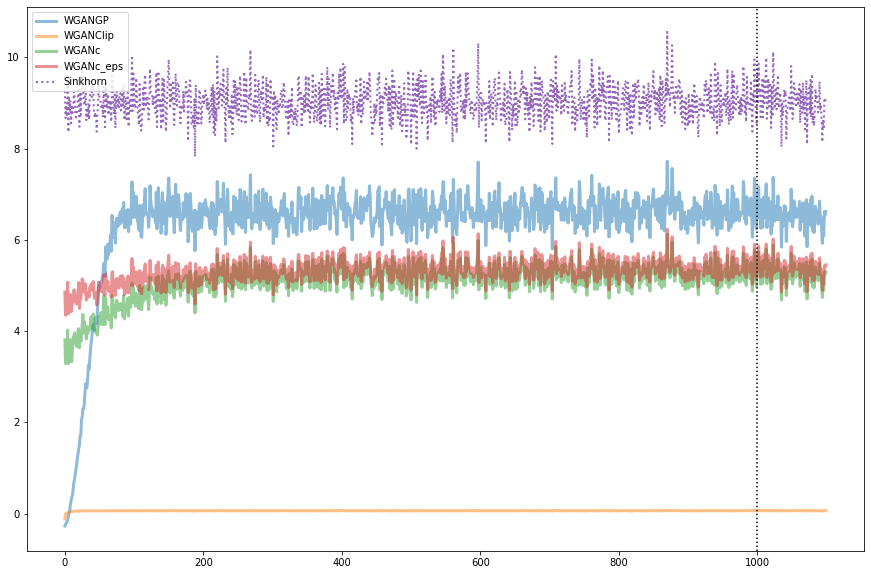

In [413]:
plt.figure(figsize=(15, 10))
for key, loss in losses.items():
    linestyle = ":" if key in ["Sinkhorn", "Wasserstain 1"] else None
    linewidth = 2 if key in ["Sinkhorn", "Wasserstain 1"] else 3
    alpha = 1 if key in ["Sinkhorn", "Wasserstain 1"] else 0.5
    plt.plot(loss, 
             label=key, 
             linestyle=linestyle,
             linewidth=linewidth,
             alpha=alpha
            )
    
plt.axvline(train_epoches, c="black", linestyle=linestyle)
plt.legend()
plt.show()

#### Layer Width influence

In [426]:
layer_width = [16, 32, 64, 128, 256, 512]

#### WGAN Clip

In [427]:
clipper = WeightClipper(0.01)
netD_Clip_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(size, width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_Clip_map = dict(zip(layer_width, [RMSprop(
                                   netD_Clip_map[width].parameters(),
                                   lr=5e-4
                                ) for width in layer_width]
                            )
                        )

#### WGAN Gradient Penalty

In [428]:
netD_GP_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(size, width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_GP_map = dict(zip(layer_width, [Adam(
                                    netD_GP_map[width].parameters(),
                                    lr=5e-4,
                                    betas=(0, 0.9)
                                ) for width in layer_width]
                            )
                        )

#### $(c)$-GAN

In [429]:
netD_C_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(size, width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_C_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_map[width].parameters(),
                                   lr=1e-4
                                ) for width in layer_width]
                            )
                        )

#### $(C, \epsilon)$-GAN

In [430]:
eps=1
netD_C_eps_map = dict(zip(layer_width, [nn.Sequential(
                                    nn.Linear(size, width),
                                    nn.ReLU(),
                                    nn.Linear(width, 1)
                                ).to(cfg["device"]) for width in layer_width]
                            )
                        )

optimD_C_eps_map = dict(zip(layer_width, [RMSprop(
                                   netD_C_eps_map[width].parameters(),
                                   lr=1e-4
                                ) for width in layer_width]
                            )
                        )

#### Sinkhorn

In [431]:
sinkhorn = Sinkhorn(eps=0.01)

#### Experiments

In [432]:
losses = {
    "WGANGP": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANClip": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "WGANc_eps": dict(zip(layer_width, [ [] for _ in layer_width ])),
    "Sinkhorn": [],
}

for epoch in (pbar := tqdm(range(train_epoches))):
    X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
    X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

    ### WGANClip
    for width in layer_width:
        optimD_Clip_map[width].zero_grad()
        e_X_1 = netD_Clip_map[width](X_1_batch).mean()
        e_X_2 = netD_Clip_map[width](X_2_batch).mean()
        netD_loss = e_X_1 - e_X_2 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_Clip_map[width].step()

        netD_Clip_map[width].apply(clipper)
        losses["WGANClip"][width].append(netD_loss.item())

    ### WGANGP
    for width in layer_width:
        optimD_GP_map[width].zero_grad()
        e_X_1 = netD_GP_map[width](X_1_batch).mean()
        e_X_2 = netD_GP_map[width](X_2_batch).mean()

        netD_loss = e_X_1 - e_X_2 

        mix_alpha = torch.rand((len(X_1_batch), 1), device=cfg['device'])
        mixed = mix_alpha * X_1_batch + (1 - mix_alpha) * X_2_batch
        mixed.requires_grad_(True)
        mixed_preds = netD_GP_map[width](mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(X_1_batch), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = -(netD_loss - cfg['w_gp'] * grad_loss)
        netD_total_loss.backward()
        optimD_GP_map[width].step()

        losses["WGANGP"][width].append(netD_loss.item())

    ### WGAN (c)
    for width in layer_width:
        optimD_C_map[width].zero_grad()
        phi_X_1 = netD_C_map[width](X_1_batch)
        phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_map[width].step()
        losses["WGANc"][width].append(netD_loss.item())
    
    ### WGAN (c, eps)
    for width in layer_width:
        optimD_C_eps_map[width].zero_grad()
        phi_X_1 = netD_C_eps_map[width](X_1_batch)
        phi_X_2 = -eps*torch.log(
                                torch.mean(
                                    torch.exp(
                                        -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                    ), 
                                1, keepdims=True)
                            )

        netD_loss = phi_X_1.mean() + phi_X_2.mean() 

        netD_total_loss = -(netD_loss)
        netD_total_loss.backward()

        optimD_C_eps_map[width].step()
        losses["WGANc_eps"][width].append(netD_loss.item())


    ### Sinhkorn
    with torch.no_grad():
        C = torch.cdist(X_1_batch, X_2_batch, p=1)
        a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
        b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
        P = sinkhorn(a, b, C/C.max(), 100)
        losses["Sinkhorn"].append((P*C).sum().item())
        
    
for epoch in (pbar := tqdm(range(val_epoches))):
    with torch.no_grad():
        X_1_batch = dist1.rsample(cfg["batch_size"]).to(cfg['device'])
        X_2_batch = dist2.rsample(cfg["batch_size"]).to(cfg['device'])

        ### WGANClip
        for width in layer_width:
            e_X_1 = netD_Clip_map[width](X_1_batch).mean()
            e_X_2 = netD_Clip_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANClip"][width].append(netD_loss.item())

        ### WGANGP
        for width in layer_width:
            e_X_1 = netD_GP_map[width](X_1_batch).mean()
            e_X_2 = netD_GP_map[width](X_2_batch).mean()
            netD_loss = e_X_1 - e_X_2 
            losses["WGANGP"][width].append(netD_loss.item())

        ### WGAN (c)
        for width in layer_width:
            phi_X_1 = netD_C_map[width](X_1_batch)
            phi_X_2, _ = (torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T).min(1, keepdims=True)
            netD_loss = phi_X_1.mean() + phi_X_2.mean() 
            losses["WGANc"][width].append(netD_loss.item())

        ### WGAN (c, eps)
        for width in layer_width:
            optimD_C_eps_map[width].zero_grad()
            phi_X_1 = netD_C_eps_map[width](X_1_batch)
            phi_X_2 = -eps*torch.log(
                                    torch.mean(
                                        torch.exp(
                                            -(1/eps)*(torch.cdist(X_2_batch, X_1_batch) - phi_X_1.T)
                                        ), 
                                    1, keepdims=True)
                                )
            netD_loss = phi_X_1.mean() + phi_X_2.mean()
            losses["WGANc_eps"][width].append(netD_loss.item())

        ### Sinhkorn
        with torch.no_grad():
            C = torch.cdist(X_1_batch, X_2_batch, p=1)
            a = torch.ones((X_1_batch.shape[0],), device=cfg["device"])/X_1_batch.shape[0]
            b = torch.ones((X_2_batch.shape[0],), device=cfg["device"])/X_2_batch.shape[0]
            P = sinkhorn(a, b, C/C.max(), 100)
            losses["Sinkhorn"].append((P*C).sum().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

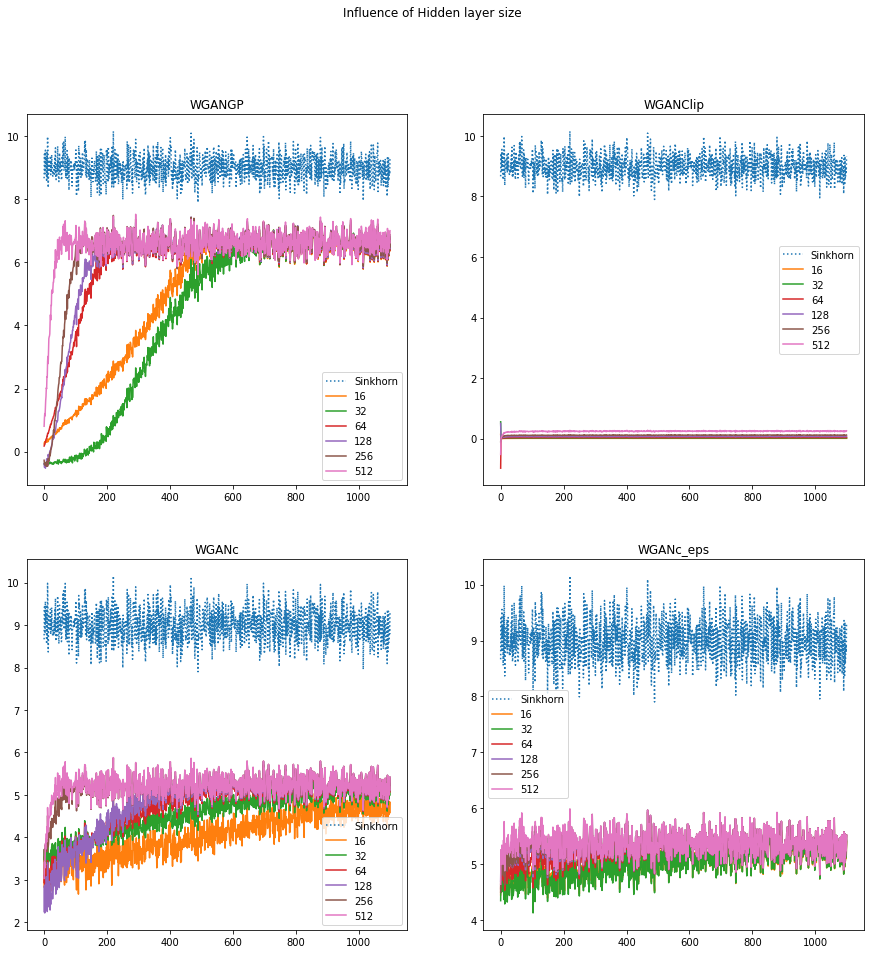

In [453]:
values = list(losses.values())
keys = list(losses.keys())

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.suptitle("Influence of Hidden layer size")
for i, ax in enumerate(axs.flatten()):
    ax.set_title(keys[i])
    ax.plot(losses["Sinkhorn"], label="Sinkhorn", linestyle = ":")
    for key, item in values[i].items():
        ax.plot(item, label=key)
    ax.legend()
        
plt.show()